In [1]:
import pandas as pd
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)


In [2]:
df = pd.read_csv("../data/gkg_20201124.csv")

### missing data
When we use Google Big Query we get 409,876 news articles on 2020-11-24 but when we use Python GDELT package we only manage to retrieve 
156,396 news articles.

Short term solution: Use Google Big Query to directly query and pull the GKG table

```
SELECT COUNT(1) FROM `gdelt-bq.gdeltv2.gkg` 
WHERE DATE >= 20201124000000
AND DATE <= 20201125000000
```

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156396 entries, 0 to 156395
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GKGRECORDID                 156396 non-null  object 
 1   DATE                        156389 non-null  float64
 2   SourceCollectionIdentifier  156389 non-null  float64
 3   SourceCommonName            156386 non-null  object 
 4   DocumentIdentifier          156389 non-null  object 
 5   Counts                      19160 non-null   object 
 6   V2Counts                    19160 non-null   object 
 7   Themes                      142899 non-null  object 
 8   V2Themes                    142898 non-null  object 
 9   Locations                   117760 non-null  object 
 10  V2Locations                 117576 non-null  object 
 11  Persons                     121502 non-null  object 
 12  V2Persons                   120257 non-null  object 
 13  Organizations 

### Pre-process themes

We will first pre-process the V2Themes column. 

Normally, as part of preprocessing, we will:
1. Tokenize
2. Lemmatize the tokens
3. Compute bigrams
4. Compute a bag-of-words representation of the data

However, we can skip step 2 and 3 here because the V2Themes column already contains proper words/themes. After tokenizing, we can directly transform the documents to a vectorized form. 

In [4]:
def pre_process_themes(df):
    # drop missing themes rows
    df = df.dropna(subset=["V2Themes"])
    # split by ';' and remove everything after ',' 
    df["V2Themes"] = [[re.sub(r',.*', '', theme) for theme in doc.split(';') if theme] for doc in df["V2Themes"].tolist()]
    return df

pre_processed_df = pre_process_themes(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
from gensim.corpora import Dictionary

# get the processed corpus
processed_corpus = pre_processed_df["V2Themes"].tolist()

# create a dictionary representation of the documents
dictionary = Dictionary(processed_corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(processed_corpus))

Number of unique tokens: 9591
Number of documents: 142898


In [6]:
# bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# sense check first and fifth corpus
print(f'Bag-of-words representation of the first document: {bow_corpus[0]}')
print(f'Bag-of-words representation of the fifth document: {bow_corpus[4]}')

Bag-of-words representation of the first document: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
Bag-of-words representation of the fifth document: [(59, 6)]


In [7]:
# Train LDA model.
from gensim.models import LdaModel, LdaMulticore

# Set training parameters.
num_topics = 8
passes = 1 # default is 1
iterations = 400 # default is 50
eval_every = 1  # to monitor convergence but set to None in production because it takes too much time 
chunksize = 2000 # increasing this will speed up training, as long as the chunk of documents can fit into memory

model = LdaMulticore(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    workers=3,
    alpha='symmetric', # 'auto' is only available in plain LDA model
    eta='auto',
#     iterations=iterations,
#     passes=passes,
#     eval_every=eval_every
)

### Compute topic coherence score

Coherence measures the relative distance between words within a topic. 

There are two major types:
- 'u_mass': -14 < x < 14 (default, uses bow_corpus)
- 'c_v': 0 < x < 1 (slower, uses processed_corpus)

[Stack Overflow](#https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad)

Alternative way: 
[Gensim Coherence Model](#https://radimrehurek.com/gensim/models/coherencemodel.html)

In [8]:
# Each element in the list is a pair of a topic representation and its coherence score. 
# Topic representations are distributions of words, represented as a list of pairs of word IDs and their probabilities.

top_topics = model.top_topics(texts=processed_corpus, coherence="c_v")

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: 0.6026.


### Word Clouds of Top N Keywords in Each Topic

In [9]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

In [10]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  min_font_size=7,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

In [12]:
# return a list of topics, each represented either as a string (when formatted == True) or  a 2-tuple of (word, probability)
topics = model.show_topics(formatted=False)

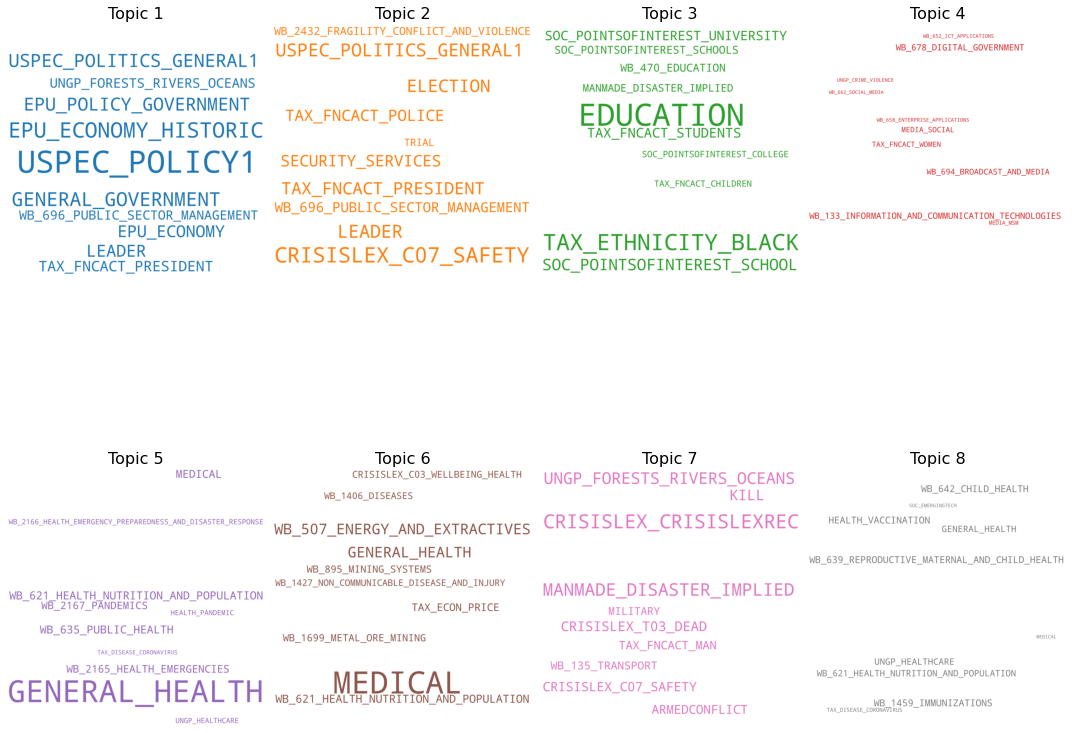

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # create dict of {word:freq}
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    ax.axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.margins(x=0, y=0)

In [14]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, bow_corpus, dictionary=model.id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.054852  0.059246       1        1  14.843320
1      0.216197  0.144068       2        1  20.094645
2      0.033222 -0.025767       3        1   7.179714
3      0.091403 -0.220602       4        1   8.124756
4     -0.159860  0.005023       5        1  19.432714
5     -0.106902 -0.075365       6        1   8.338012
6      0.121774  0.020932       7        1  13.858276
7     -0.250686  0.092465       8        1   8.128562, topic_info=                                              Term           Freq          Total Category  logprob  loglift
59                                       EDUCATION   68237.000000   68237.000000  Default  30.0000  30.0000
5                                  UNGP_HEALTHCARE  102473.000000  102473.000000  Default  29.0000  29.0000
94   WB_639_REPRODUCTIVE_MATERNAL_AND_CHILD_HEALTH   47401.000000   47401.000000  Default  28.0000  28.0000
95                             WB_642_CHILD_HEALTH   46521.000000   46521.000000  Default  27.0000  27.0000
93                           WB_1459_IMMUNIZATIONS   46497.000000   46497.000000  Default  26.0000  26.0000
..                                             ...            ...            ...      ...      ...      ...
119                                         LEADER    4739.367226   92129.130824   Topic8  -4.7551  -0.4575
10                            WB_635_PUBLIC_HEALTH    3217.445879   80319.933660   Topic8  -5.1424  -0.7076
2                                  HEALTH_PANDEMIC    2976.502779   64513.425606   Topic8  -5.2202  -0.5663
104                     UNGP_FORESTS_RIVERS_OCEANS    2886.773230   74303.837909   Topic8  -5.2509  -0.7382
8                                WB_2167_PANDEMICS    2727.575998   66938.310042   Topic8  -5.3076  -0.6906

[712 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
433       1  0.094380                        AFFECT
433       2  0.119677                        AFFECT
433       3  0.072043                        AFFECT
433       4  0.082915                        AFFECT
433       5  0.225479                        AFFECT
...     ...       ...                           ...
517       5  0.008026         WB_895_MINING_SYSTEMS
517       6  0.968260         WB_895_MINING_SYSTEMS
517       7  0.003849         WB_895_MINING_SYSTEMS
517       8  0.002293         WB_895_MINING_SYSTEMS
5004      2  0.988463  WB_945_JUDICIAL_INDEPENDENCE

[3012 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
from pyLDAvis import save_html

save_html(vis, "lda_vis.html")

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
